In [6]:
import numpy as np

## Options

A **call option** is a financial contract giving the holder the right, but not the obligation, to buy an asset at a predetermined price \(K\) (the strike price) at a specified future time $T$ (the maturity).

The payoff of a **European call option** at maturity depends on the terminal stock price \(S_T\):

$$
\text{Payoff at } T: (S_T - K)^+ = \max(S_T - K, 0)
$$

- If $S_T > K$, the option is **in the money**, and the holder profits $S_T - K$.  
- If $S_T \le K$, the option expires worthless.

<!-- Similarly, a **European put option** has payoff:

$$
\boxed{(K - S_T)^+ = \max(K - S_T, 0)}
$$ -->

The **option price today** is the discounted expected value of the payoff under the **risk-neutral measure** $\mathbb{Q}$:

$$
C(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(S_T - K)^+]%, \quad P(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(K - S_T)^+]
$$

where $\tau = T - t$.


## Heston Model

Before the implementation of the double Heston model, having a working implementation of the standard Heston model (Heston, 1993) is convenient.

In the Heston model the evolution of the stock price $S_t$ and its variance $v_t$ is defined by the following system of stochastic differential equations (under the risk neutral measure): 

$$
\begin{aligned}
d S_t &= (r-q) S_t dt + \sqrt v_t S_t d W_{1, t} \\
d v_t & = \kappa (\theta - v_t) dt + \sigma \sqrt v_t d W_{2, t},
\end{aligned}
$$
where  $W_{1,t}, W_{2,t}$ are Brownian motions, $E^{\mathbb{Q}}[dW_{1,t},dW_{2,t}]= \rho dt$ for the risk-neutral measure $\mathbb{Q}$ and

$r$: risk-free interest rate  
$q$: continuous dividend yield  
$\kappa >0$: mean reversion speed for the variance  
$\theta>0$: mean reversion level for the variance  
$\sigma > 0$: volatility of the variance  
$\rho \in [-1,1]$: correlation between $d W_{1,t}$ and $d W_{2,t}$

### Monte Carlo Simulations (Heston)

To calculate the price numerically, we use Monte Carlo simulations. In Monte Carlo pricing $S_T$ is obtained by simulating the underlying stochastic process (i.e. Heston SDE) up to maturity $N$ times, which results in $N$ stock price paths. The price is then calculated as the discounted average of the payoffs for all the paths. We use an Euler discretization for the system of SDEs.

#### Brownian Motions



In the Euler discretization we will have $dW_{1,t}$ and $dW_{2,t}$ corresponding to differences in time of the two Brownian motions. To guarantee that $dW_{1,t}$ and $dW_{2,t}$ have $\rho$ correlation as required by the model, we generate random variables $Z_1, Z_2 \sim \mathcal{N}(0,1)$, define
$$
\boxed{
\begin{aligned}
Z_V &= Z_1 \\
Z_S &= \rho Z_V + \sqrt {1-\rho^2} Z_2,
\end{aligned}
}
$$
and make
\begin{aligned}
dW_{1,t} &= \sqrt{dt} Z_S \\
dW_{2,t} &= \sqrt{dt} Z_V.
\end{aligned}

By construction, $E[Z_V]=E[Z_S]=0$ and therefore $E[Z_V Z_S]=\rho E[Z_1^2] + \sqrt{1-\rho^2} E[Z_1 Z_2]= \rho$





#### Euler Scheme (Heston)

Using Ito's lemma for the equation for the stock price yields in integral form
$$\ln S_{t+dt} = \ln S_t + \int_{t}^{t+dt} \left( r - q - \frac{1}{2} v_u \right) du + \int_{t}^{t+dt} \sqrt v_u d W_{1,u}$$.
The Euler discretization for the process $ln S_t$ is then
\begin{align}
\ln S_{t+dt} &\approx \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t (W_{1,t+dt} - W_{1,t}) \\
 & = \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t \sqrt{dt} Z_s.
\end{align}
From which we obtain
$$\boxed{S_{t+dt} = S_t \exp \left( \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt{v_t} \sqrt{dt} Z_S \right).}$$

The integral form for the SDE for $v_t$ and corresponding Euler discretization are
\begin{align}
v_{t+dt} &= v_t + \int_{t}^{t+dt} \kappa (\theta - v_u) du + \int_{t}^{t+dt} \sigma \sqrt{v_u} dW_{2,u} \\
& \approx v_t+ \kappa (\theta -v_t) dt + \sigma \sqrt{v_t} (W_{2,t+dt}-W_{2,t}),
\end{align}
which gives the following Euler discretization for the variance
$$ \boxed{v_{t+dt} = v_t + \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} \sqrt{dt} Z_V}.$$

To avoid negative variances, we adopt the full truncation scheme, i.e. $v_t$ is replaced by $v_t^+= \max(0,v_t)$.

#### Monte Carlo Price

The Monte Carlo price is calculated using
$$\boxed{ C(K) = e^{-r \tau} \frac{1}{N} \sum_{i=1}^N \max(S^{(i)}_T-K,0) }$$
where $S^{(i)}_T$ is the terminal stock price in the stock price path $i=1, \ldots, N$.

#### Simulations (Heston)

In [208]:
#Code goes here

def heston_simulate_paths(N_paths, N_steps, T, S0, v0, r=0.03, q=0.02, kappa=5.0, theta=0.05, sigma=0.5, rho=-0.8):
    
    # Define Brownian noises for all paths and steps
    rng = np.random.default_rng(20)
    Z_1 = rng.standard_normal((N_paths, N_steps))
    Z_2 = rng.standard_normal((N_paths, N_steps))
    Z_V = Z_1
    Z_S = rho* Z_V + np.sqrt(1-rho**2)*Z_2

    # Euler scheme
    dt= T/(N_steps-1)
    
    S = np.zeros((N_paths, N_steps))
    V = np.zeros((N_paths, N_steps))

    S[:,0]= S0
    V[:,0]= v0

    for step in range(1, N_steps):
        V[:,step] = V[:,step-1] + kappa*(theta-V[:,step-1])*dt+sigma*np.sqrt(V[:,step-1])*np.sqrt(dt)*Z_V[:, step]
        V[:,step] = np.maximum(V[:,step],0)
        S[:,step] = S[:, step-1]*np.exp((r-q-1/2*V[:,step-1])*dt + np.sqrt(V[:,step-1])*np.sqrt(dt)*Z_S[:,step])
    return S, V

def heston_mc_price(S_paths, K, T, r=0.03):
    S_T = S_paths[:,-1]
    payoffs = np.maximum (S_T-K,0)
    return np.exp(-r*T)*np.mean(payoffs)

# Reference values. T=0.5, S=100, K=100, q=0.02, r=0.03, kappa=5, sigma=0.5, rho=-0.8, theta=v0=0.05, 
# trapezoid rule with phi in [0.00001,50], increments of 0.001, 
# Put: 5.7590, Call: 6.2528
# If q=0 (no dividend)
# Put: 5.3790, Call: 6.8678


In [212]:
# Path simulations
S, V = heston_simulate_paths(N_paths=50000,N_steps=200,T=0.5,S0=100,v0=0.05)
heston_mc_price(S_paths=S,K=100, T=0.5)

np.float64(6.277166549025437)

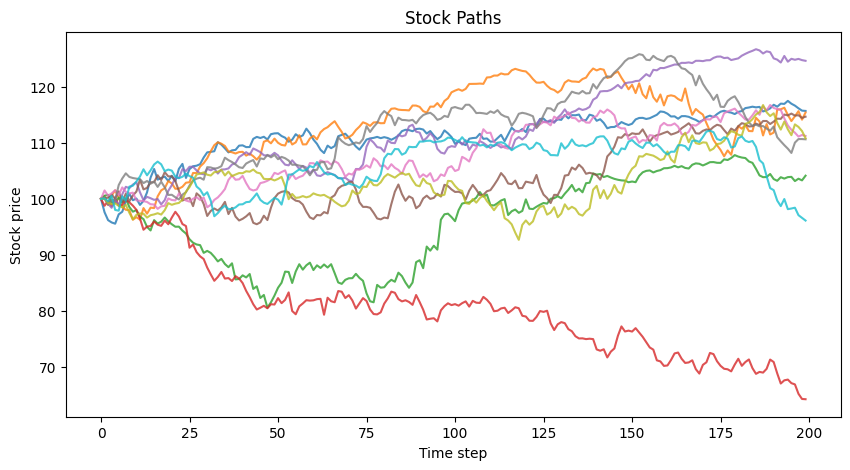

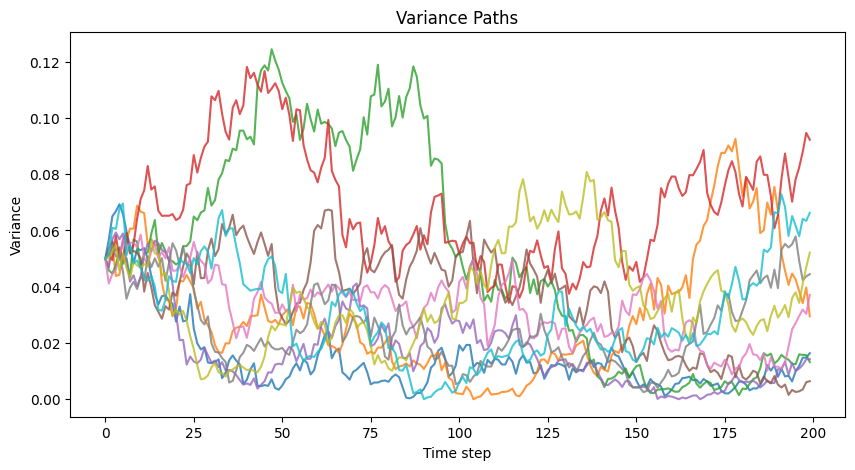

In [213]:
S_example, V_example = heston_simulate_paths(N_paths=10,N_steps=200, T=0.5, S0=100, v0=0.05)
plot_paths(S_example,V_example)

### Exact price (Heston)

The price of a call option for the Heston model is given by the formula
$$\boxed{ C(K) = S_t e^{-q \tau} P_1 - K e^{-r \tau} P_2}$$
where 
$$ \boxed{ P _j = P(\ln S_T > K) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} \Re \left[\frac{e^{-i \phi \ln K} f_j (\phi; x_t,v_t)}{i \phi}\right] d \phi }$$.  
The functions $f_1, f_2$ are characteristic functions for the logarithm of the terminal stock price, $x_T = \ln S_T$:

$$\boxed{f_j(\phi; x_t,v_t) = \exp (C_j(\tau, \phi)+D_j(\tau, \phi) v_t+i \phi x_t),}$$
where $\tau = T-t$ is the time to maturity.

The expressions for $C_j(\tau, \phi)$ and $D_j(\tau, \phi)$ are
$$
\boxed{
\begin{align}
C_j (\tau, \phi) &= (r-q) i \phi \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i \phi - d_j) \tau - 2 \ln \left( \frac{1- c_j e^{-d_j \tau}}{1-c_j} \right) \right] \\
D_j(\tau, \phi) &= \frac{b_j - \rho \sigma i \phi-d_j}{\sigma^2} \left(\frac{1-e^{-d_j \tau}}{1-c_j e^{-d_j \tau}} \right).
\end{align}
}$$
Here, we have
$$
\boxed{
\begin{align}
c_j &= \frac{b_j - \rho \sigma i \phi - d_j}{b_j - \rho \sigma i \phi + d_j} \\
b_1 & = \kappa - \rho \sigma \\
b_2 &= \kappa \\
d_j &= \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2 (2 u_j i \phi - \phi^2)} \\
u_1 &= \frac{1}{2} \\
u_2 &=- \frac{1}{2}.
\end{align}
}
$$

These formulas use the Heston trap formulation for numerical stability. We take the principal branch of the complex root and logarithm in $d_j$ and $C_j$. The integral in $P_j$ is calculated numerically using the trapezoidal rule.

In [241]:
# code goes here
# heston_cf_integrand(S0,v0,r, kappa, theta, sigma, rho, T, K)
def heston_cf_integrand(phi, Pnum, K, tau, S, v, r=0.03, q=0.02, kappa=5.0, theta=0.05, sigma=0.5, rho=-0.8):
    """
    Returns the integrand for the risk neutral probabilities P1 and P2 needed in the formula for the price
    
    Parameters
    ----------
    phi : Integration varible
    Pnum : 1 or 2 (to choose P1 or P2)
    
    K: Strike price
    S: Spot price (Price at time t)
    tau: Time to maturity (T-t)
    r: Risk free rate
    q: Dividend yield

    v: Spot variance
    kappa: volatility mean reversion speed
    theta: volatility mean reversion level
    sigma: volatility of the variance
    rho: correlation between the Brownian motions
    """

    x = np.log(S)
    
    if Pnum==1:
        b = kappa - rho*sigma
        u = 1/2
    elif Pnum==2:
        b= kappa
        u = -1/2
    else:
        raise ValueError(f"Invalid Pnum: {Pnum}. Must be 1 or 2.")

    d = np.sqrt((rho*sigma*1j*phi-b)**2-sigma**2*(2*u*1j*phi-phi**2))
    c = (b-rho*sigma*1j*phi-d)/(b-rho*sigma*1j*phi+d)

    D = (b-rho*sigma*1j*phi-d)/sigma**2*((1-np.exp(-d*tau))/(1-c*np.exp(-d*tau)))
    G = (1-c*np.exp(-d*tau))/(1-c)
    C = (r-q)*1j*phi*tau + (kappa*theta)/sigma**2*((b-rho*sigma*1j*phi-d)*tau-2*np.log(G))

    f = np.exp(C+D*v+1j*phi*x)

    integrand = np.exp(-1j*phi*np.log(K))*f/(1j*phi)
    
    return integrand.real

def heston_cf_price(Lphi,Uphi,dphi, K, tau, S, v, r=0.03, q=0.02, kappa=5.0, theta=0.05, sigma=0.5, rho=-0.8):

    # Check this function
    
    # Integration grid
    phi = np.arange(Lphi, Uphi + dphi, dphi)
    N = len(phi)

    # Integrands for P1 and P2 (real-valued)
    int1 = np.zeros(N)
    int2 = np.zeros(N)

    for k in range(N):
        int1[k] = heston_cf_integrand(phi[k], 1, K, tau, S, v, r, q, kappa, theta, sigma, rho)
        int2[k] = heston_cf_integrand(phi[k], 2, K, tau, S, v, r, q, kappa, theta, sigma, rho)

    # Integrals
    I1 = np.trapezoid(int1, dx=dphi)
    I2 = np.trapezoid(int2, dx=dphi)

    # Probabilities
    P1 = 0.5 + I1 / np.pi
    P2 = 0.5 + I2 / np.pi

    # Call price
    call_price = S * np.exp(-q * tau) * P1 - K * np.exp(-r * tau) * P2

    return call_price
    

In [242]:
# Comparison between Monte Carlo and exact price
#heston_cf_integrand(phi=0.2, Pnum=2, K=100, tau=0.5, S=100, v=0.05)
heston_cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, K=100, tau=0.5, S=100, v=0.05)

np.float64(6.25281898948969)

## Double Heston Model

Describe the model with equations here.

### Monte Carlo Simulations (Double Heston)

#### Brownian motions

Describe how the Brownian motions are simulated.

#### Euler Scheme (Double Heston)

Describe the Euler scheme for the SDEs.

#### Simulations (Double Heston)

In [ ]:
#Code goes here
# doubleheston_simulate_paths(S0, v0_1, v0_2, r, kappa1, theta1, sigma1, rho1,kappa2, theta2, sigma2, rho2, rho12, T, N_steps, N_paths)
# doubleheston_mc_price(S_paths, K, r, T, option_type='call')

In [12]:
# Path simulations

### Exact Price (Double Heston)

Formulas go here.

In [13]:
# Code goes here
# dobleheston_cf_price(S0,v0_1, v0_2,r,kappa1, theta1, sigma1, rho1,
# kappa2, theta2, sigma2, rho2,rho12,T, K) # not so sure about the arguments for this one, but we'll find out

In [14]:
# Comparison between Monte Carlo and exact price

## References

Heston, S.L., 1993. A closed-form solution for options with stochastic volatility with applications to bond and currency options. The review of financial studies, 6(2), pp.327-343.

Rouah, F.D., 2013. The Heston model and its extensions in Matlab and C. John Wiley & Sons.

### Development notes

In [ ]:
# Note that you can also create a super class, and add these methods as methods of that class (that is, the class would have 'simulate_paths', 'mc_price', 'cf_price')
# Let us start with Euler scheme and trapezoidal integration with the Heston trap trick

In [45]:
# Other functions
import matplotlib.pyplot as plt
import numpy as np

def plot_paths(S=None, V=None):
    """
    Plots simulated Heston paths using the 'tab20c' colormap.
    
    Parameters
    ----------
    S : np.array or None
        Stock price paths, shape (N_paths, N_steps)
    V : np.array or None
        Variance paths, shape (N_paths, N_steps)
    """
    if S is None and V is None:
        raise ValueError("At least one of S or V must be provided.")
    
    cmap = plt.get_cmap('tab20')
    
    if S is not None:
        plt.figure(figsize=(10, 5))
        n_paths = S.shape[0]
        for i in range(n_paths):
            plt.plot(S[i,:], color=cmap(i / n_paths), alpha=0.8)
        plt.title('Stock Paths')
        plt.xlabel('Time step')
        plt.ylabel('Stock price')
        plt.show()
    
    if V is not None:
        plt.figure(figsize=(10, 5))
        n_paths = V.shape[0]
        for i in range(n_paths):
            plt.plot(V[i,:], color=cmap(i / n_paths), alpha=0.8)
        plt.title('Variance Paths')
        plt.xlabel('Time step')
        plt.ylabel('Variance')
        plt.show()